# Importing important libararies to use keras and images 

In [3]:
from __future__ import print_function
import keras
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import cv2

Using TensorFlow backend.


# Fixing some HyperParameters for the training and image size

In [4]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
batch_size = 128#how many batches at a time to fasten our training
num_classes = 19#number of classes (Geez digits we need)
epochs = 10 #how many iteration we need for the models to learn 
img_rows= 64 #fixing the image row
img_cols = 64 #fixing image height
num_pixels = img_cols*img_rows #total number of pixels we have after fixing the images

# We need to shafle the data to make our training robust and not biased by the sequence of data

In [5]:
# load data
def shaffle_Normalize(data,labels):
    X_train = data / 255
    s = np.arange(X_train.shape[0])
    np.random.shuffle(s)
    X_train=X_train[s]
    y_train=labels[s]
    return X_train,y_train

# A function  to load the preprocessed data for training, it calls the shaffle function

In [6]:
def load_data():
    data=np.load('GeezDigitsDataset.npy')
    labels=np.load('One_Hot_labels.npy')
    X_train,y_train=shaffle_Normalize(data,labels)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)
    return X_train,y_train,X_test,y_test


# The following function is to prepare the data for training, it used the load function to load data

In [7]:
def prepare4training():
    batch_size = 128
    num_classes = 19
    epochs = 10
    X_train,y_train,X_test,y_test=load_data()
    # input image dimensions
    img_rows, img_cols = 64, 64

    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
        input_shape = (3, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    return X_train,y_train,X_test,y_test


# Now the data is ready we start building the neural network models

The MLP base line have one input layer one hidden layer and one ouput layer

In [8]:
#ase line a Multilayer perceptron (MLP)
def baseline_model():
    # create model
    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols,3)))
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    #model.add(Flatten(input_shape=(img_rows, img_cols,3)))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Buildinf CNN baseline
It has one Convolutional input layer one Convolutional hidden layer, one linear hidden layer 
and one fully connected ouput layer

In [9]:
def baseline_model_CNN():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(64, 64,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# A little Larger baseline CNN

In [18]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Buliding Best CNN model with conrolling overfitting using drop out and batch normalization
It has one input layer, 3 convolutional hidden layer and one linear hidden layer and then an ouput layer
it uses maximum pooling to narrow data the interesting area of the cnn

In [10]:
def builgCNN():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
    model.add(Activation('relu'))
    BatchNormalization(axis=-1)
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    BatchNormalization(axis=-1)
    model.add(Conv2D(64,(3, 3)))
    model.add(Activation('relu'))
    BatchNormalization(axis=-1)
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    # Fully connected layer

    BatchNormalization()
    model.add(Dense(512))
    model.add(Activation('relu'))
    BatchNormalization()
    model.add(Dropout(0.2))
    model.add(Dense(19))

    model.add(Activation('softmax'))

    return model

# Now it time to train the sytem usinf the function train 
which takes a NN model and the training data as input

In [11]:
def trainingModel(model,X_train,y_train,X_test,y_test,model_name):
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

    """history=model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_data=(X_test, y_test))"""
    history = model.fit(X_train, y_train, validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=2)
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    #fig = plt.figure(figsize=(12,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Accuracy_model_'+str(model_name))
    #plt.show()
    # summarize history for loss
    #plt.close(fig)
    #fig = plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Loss_model_'+str(model_name))
    #plt.close(fig)

    with open('history_model_'+str(model_name)+'.json', 'w') as f:
        json.dump(history.history, f)

    model.save('mnist_keras_cnn_model.h5')


# For training we pepare the data first so we call the prepare4training function as follows

In [12]:
X_train,y_train,X_test,y_test=prepare4training()

X_train shape: (7125, 64, 64, 3)
7125 train samples
2375 test samples


# Then we build the model and call the trainingModel function giving the models built

Train on 4773 samples, validate on 2352 samples
Epoch 1/10
 - 55s - loss: 15.2726 - acc: 0.0524 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 2/10
 - 53s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 3/10
 - 50s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 4/10
 - 50s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 5/10
 - 50s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 6/10
 - 49s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 7/10
 - 54s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 8/10
 - 51s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 9/10
 - 49s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
Epoch 10/10
 - 51s - loss: 15.2772 - acc: 0.0522 - val_loss: 15.2683 - val_acc: 0.0527
2375/2375 [==============================] - 9s 4ms/step
Test loss: 15.256201149388364
Test

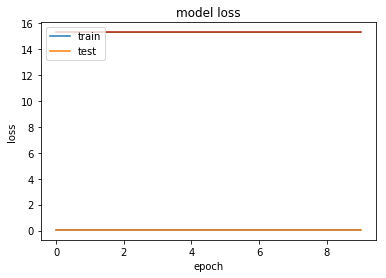

In [67]:
model=baseline_model()
trainingModel(model,X_train,y_train,X_test,y_test,'baseline_MLP')

Train on 4773 samples, validate on 2352 samples
Epoch 1/10
 - 26s - loss: 3.1732 - acc: 0.0765 - val_loss: 2.9289 - val_acc: 0.0910
Epoch 2/10
 - 26s - loss: 2.8429 - acc: 0.1925 - val_loss: 2.6938 - val_acc: 0.3253
Epoch 3/10
 - 26s - loss: 2.3759 - acc: 0.4054 - val_loss: 2.0894 - val_acc: 0.4418
Epoch 4/10
 - 26s - loss: 1.7410 - acc: 0.5577 - val_loss: 1.6533 - val_acc: 0.5608
Epoch 5/10
 - 26s - loss: 1.3532 - acc: 0.6411 - val_loss: 1.3966 - val_acc: 0.6190
Epoch 6/10
 - 26s - loss: 1.1145 - acc: 0.7038 - val_loss: 1.2964 - val_acc: 0.6327
Epoch 7/10
 - 26s - loss: 0.9206 - acc: 0.7526 - val_loss: 1.1573 - val_acc: 0.6773
Epoch 8/10
 - 26s - loss: 0.7814 - acc: 0.7949 - val_loss: 1.1342 - val_acc: 0.6777
Epoch 9/10
 - 26s - loss: 0.6666 - acc: 0.8295 - val_loss: 1.1058 - val_acc: 0.6764
Epoch 10/10
 - 26s - loss: 0.5725 - acc: 0.8527 - val_loss: 1.0511 - val_acc: 0.6943
2375/2375 [==============================] - 4s 2ms/step
Test loss: 1.1295916071941978
Test accuracy: 0.6652631

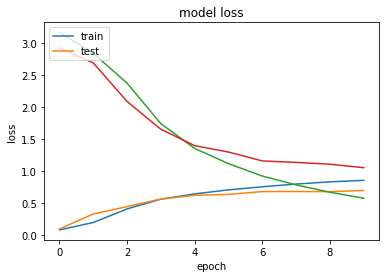

In [13]:
model=baseline_model_CNN()
trainingModel(model,X_train,y_train,X_test,y_test,'baseline_CNN')

Train on 4773 samples, validate on 2352 samples
Epoch 1/10
 - 83s - loss: 2.3959 - acc: 0.2778 - val_loss: 1.4307 - val_acc: 0.5978
Epoch 2/10
 - 82s - loss: 1.2518 - acc: 0.6231 - val_loss: 0.9725 - val_acc: 0.7109
Epoch 3/10
 - 82s - loss: 0.7902 - acc: 0.7593 - val_loss: 0.6590 - val_acc: 0.7997
Epoch 4/10
 - 84s - loss: 0.4885 - acc: 0.8414 - val_loss: 0.5439 - val_acc: 0.8397
Epoch 5/10
 - 82s - loss: 0.3116 - acc: 0.9005 - val_loss: 0.4859 - val_acc: 0.8499
Epoch 6/10
 - 82s - loss: 0.1970 - acc: 0.9359 - val_loss: 0.4576 - val_acc: 0.8720
Epoch 7/10
 - 82s - loss: 0.1308 - acc: 0.9573 - val_loss: 0.4716 - val_acc: 0.8810
Epoch 8/10
 - 84s - loss: 0.0853 - acc: 0.9711 - val_loss: 0.4600 - val_acc: 0.8771
Epoch 9/10
 - 80s - loss: 0.0558 - acc: 0.9818 - val_loss: 0.4827 - val_acc: 0.8793
Epoch 10/10
 - 80s - loss: 0.0454 - acc: 0.9868 - val_loss: 0.5405 - val_acc: 0.8801
2375/2375 [==============================] - 10s 4ms/step
Test loss: 0.5476253169775009
Test accuracy: 0.886315

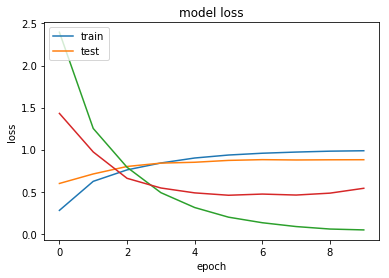

In [14]:
model=builgCNN()
trainingModel(model,X_train,y_train,X_test,y_test,'Best_CNN')

Train on 4773 samples, validate on 2352 samples
Epoch 1/10
 - 32s - loss: 2.9308 - acc: 0.0819 - val_loss: 2.8146 - val_acc: 0.2147
Epoch 2/10
 - 34s - loss: 2.3832 - acc: 0.2986 - val_loss: 1.9351 - val_acc: 0.4660
Epoch 3/10
 - 31s - loss: 1.5957 - acc: 0.5292 - val_loss: 1.3786 - val_acc: 0.5863
Epoch 4/10
 - 31s - loss: 1.2643 - acc: 0.6195 - val_loss: 1.3716 - val_acc: 0.6199
Epoch 5/10
 - 31s - loss: 1.1280 - acc: 0.6706 - val_loss: 1.0868 - val_acc: 0.6752
Epoch 6/10
 - 31s - loss: 1.0124 - acc: 0.7002 - val_loss: 1.1116 - val_acc: 0.6747
Epoch 7/10
 - 31s - loss: 0.9753 - acc: 0.7178 - val_loss: 1.0519 - val_acc: 0.6922
Epoch 8/10
 - 31s - loss: 0.8452 - acc: 0.7463 - val_loss: 0.9094 - val_acc: 0.7219
Epoch 9/10
 - 31s - loss: 0.7548 - acc: 0.7765 - val_loss: 0.8476 - val_acc: 0.7449
Epoch 10/10
 - 34s - loss: 0.6777 - acc: 0.7934 - val_loss: 0.8157 - val_acc: 0.7487
2375/2375 [==============================] - 5s 2ms/step
Test loss: 0.9041769968835931
Test accuracy: 0.7221052

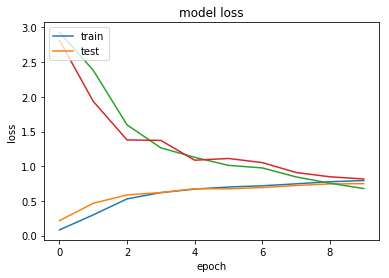

In [19]:
model=larger_model()
trainingModel(model,X_train,y_train,X_test,y_test,'largeBS_CNN')

In [41]:
def print_prediction(imageFile):
    geezDigitList=['፩', '፪', '፫', '፬', '፭', '፮', '፯', '፰', '፱ ', '፲', '፳', '፴', '፵', '፶ ', '፷', '፸ ', '፹', '፺', '፻']
    geezDigitListRevesed=["፻","፺","፹","፸ ","፷","፶ ","፵","፴","፳","፲","፱ ","፰","፯","፮","፭","፬","፫","፪","፩"]
    Labels=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
    img='/home/berhe/Desktop/Geni_Project/Hand-written-digit-Recognition-Project/Data collected/Abeba Araya/50.JPG'

    full_size_image=cv2.imread(imageFile)
    cv2.imshow('input image',full_size_image)
    image=cv2.resize(full_size_image,(64, 64),interpolation=cv2.INTER_CUBIC)
    image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #print('Image shape: {}'.fromat((image.shape)))
    #image.show()
    classes = model.predict_classes(image)
    print(classes[0])
    print('The hand written digit is :{}'.format(Labels[classes[0]]))
    print('The equivalent Geez Digit is: {}'.format(geezDigitList[classes[0]]))

In [42]:
%matplotlib inline

In [43]:
img='/home/berhe/Desktop/Geni_Project/Hand-written-digit-Recognition-Project/Data collected/Abeba Araya/50.JPG'
print_prediction(img)

14
The hand written digit is :60
The equivalent Geez Digit is: ፷


In [66]:
img='/home/berhe/Desktop/Geni_Project/Hand-written-digit-Recognition-Project/Data collected/Abeba Araya/90.JPG'
print_prediction(img)

18
The hand written digit is :100
The equivalent Geez Digit is: ፻


We can also see which class is choosen : the one wh=ith beggest probability is the class

In [64]:
def prediction(imageFile):
    full_size_image=cv2.imread(imageFile)
    cv2.imshow('input image',full_size_image)
    image=cv2.resize(full_size_image,(64, 64),interpolation=cv2.INTER_CUBIC)
    image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #print('Image shape: {}'.fromat((image.shape)))
    #image.show()
    classes = model.predict_proba(image)
    print(classes)
    

In [65]:
prediction(img)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
